# Main Result
This version removes validation samples from sites with no training data from the within-site results

## Initialisation

In [1]:
import glob
import json
import numpy as np
import os
import pandas as pd
import seaborn as sns

from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple, HandlerPatch
import matplotlib.text as mpl_text
from matplotlib.patches import ConnectionPatch, Rectangle

import initialise
import common
from analysis_utils import calc_statistics, grouped_results
from display_utils import display_frames

In [2]:
%matplotlib inline

In [3]:
samples_file = os.path.join(common.DATASETS_DIR, 'samples_730days.csv')
model_dir = os.path.join(common.MODELS_DIR, 'evaluation_models')

In [4]:
model = common.ANALYSIS_MODEL
ensemble_size = common.ENSEMBLE_SIZE
ensemble_runs = common.ENSEMBLE_RUNS
precision = 2

## Get the samples and predictions

In [5]:
def sort_file_list(file_list, basename_prefix):
    return sorted(
        file_list,
        key=lambda x: int(os.path.splitext(x)[0].rsplit(basename_prefix, 1)[1] or 0)
        )

In [6]:
stats_list = []
test_list = []
num_samples = []
num_predicts = []
samples = pd.read_csv(samples_file, index_col=0)
with open(os.path.join(model_dir, 'experiment.json'), 'r') as f:
    experiment = json.load(f)
test_dirs = sort_file_list(glob.glob(os.path.join(model_dir, f'test*')), 'test')
for test_num, test_dir in enumerate(test_dirs):
    stats_ = pd.read_csv(os.path.join(test_dir, f'ensemble{ensemble_size}_stats.csv'), index_col=(0,1))
    stats_list.append(stats_.loc[model].mean(axis=1))
    try:
        tn = experiment['tests'][test_num].get('testName') or experiment['testNames'][test_num]
    except:
        tn = f'Test {test_num}'
    test_list.append(tn)
    num_samples.append(samples.shape[0])

In [7]:
stats_df = pd.DataFrame(stats_list, index=test_list)
stats_df['#Samples'] = num_samples
stats_df.round(3)

,Count,RMSE,R2,Bias,#Samples
Nowcasting,21520.0,26.519,0.507,1.207,66411
1-month lead time,21520.0,27.194,0.481,1.318,66411
2-months lead time,21520.0,27.485,0.470,1.182,66411
3-months lead time,21520.0,27.521,0.469,1.385,66411
4-months lead time,21520.0,27.495,0.470,1.715,66411
5-months lead time,21520.0,27.655,0.463,1.968,66411
6-months lead time,21520.0,27.858,0.456,1.762,66411
7-months lead time,21520.0,27.856,0.456,1.237,66411
8-months lead time,21520.0,27.892,0.454,1.061,66411
9-months lead time,21520.0,27.993,0.450,0.952,66411


In [8]:
with open(os.path.join(model_dir, 'model_params.json'), 'r') as f:
    params = json.load(f)
predicts = []
for test_num, test_dir in enumerate(test_dirs):
    predicts.append(pd.read_csv(os.path.join(test_dir, f'ensemble{ensemble_size}_{model}.csv'), index_col=0))

In [9]:
samples1 = samples.reindex(predicts[0].index)
yearly_summ = samples1.groupby(['Sampling year']).agg(**{
    "Sample count": pd.NamedAgg(column=params['targetColumn'], aggfunc="count"),
    "LFMC minimum": pd.NamedAgg(column=params['targetColumn'], aggfunc="min"),
    "LFMC median": pd.NamedAgg(column=params['targetColumn'], aggfunc="median"),
    "LFMC mean": pd.NamedAgg(column=params['targetColumn'], aggfunc="mean"),
    "LFMC maximum": pd.NamedAgg(column=params['targetColumn'], aggfunc="max"),
    "LFMC std": pd.NamedAgg(column=params['targetColumn'], aggfunc="std"),
}).round(2)

rmse_df = grouped_results(samples1, predicts, 'Sampling year', params['targetColumn'], test_list, measures='RMSE')
rmse_df = pd.concat([stats_df.RMSE, rmse_df], axis=1)
rmse_df.rename(columns={'RMSE': 'All'}, inplace=True)

r2_df = grouped_results(samples1, predicts, 'Sampling year', params['targetColumn'], test_list, measures='R2')
r2_df = pd.concat([stats_df.R2, r2_df], axis=1)
r2_df.rename(columns={'R2': 'All'}, inplace=True)

bias_df = grouped_results(samples1, predicts, 'Sampling year', params['targetColumn'], test_list, measures='Bias')
bias_df = pd.concat([stats_df.Bias, bias_df], axis=1)
bias_df.rename(columns={'Bias': 'All'}, inplace=True)

In [10]:
summ_stats = [samples[params['targetColumn']].describe(), samples1[params['targetColumn']].describe()]
for test_ in predicts:
    summ_stats.append(test_.mean(axis=1).describe())
summ_stats = pd.DataFrame(summ_stats, index=['All samples', 'Evaluation samples'] + test_list,
                          columns=['count', 'min', '50%', 'mean', 'max', 'std']).round(1)
summ_stats.columns = ['count', 'min', 'median', 'mean', 'max', 'std']
summ_stats

,count,min,median,mean,max,std
All samples,66411.0,1.0,102.8,109.1,477.0,37.1
Evaluation samples,21520.0,1.0,102.7,108.4,434.5,37.8
Nowcasting,21520.0,52.5,107.5,109.6,251.6,26.4
1-month lead time,21520.0,53.3,107.8,109.7,249.9,25.8
2-months lead time,21520.0,52.2,107.5,109.6,266.9,25.5
3-months lead time,21520.0,53.7,107.4,109.8,274.7,25.7
4-months lead time,21520.0,53.1,107.9,110.1,264.5,25.8
5-months lead time,21520.0,49.9,108.3,110.4,238.3,25.2
6-months lead time,21520.0,47.9,108.3,110.2,222.9,25.2
7-months lead time,21520.0,46.9,107.8,109.7,231.9,25.0


In [11]:
print("Number of samples with LFMC <= 40:",
      samples1[samples1[params['targetColumn']] <= 40][params['targetColumn']].count())
print("Number of samples with LFMC >= 255:",
      samples1[samples1[params['targetColumn']] >= 255][params['targetColumn']].count())
print("Kurtosis of all evaluation samples:",
      samples1[params['targetColumn']].kurt().round(2))
print("Kurtosis where LFMC > 40:",
      samples1[samples1[params['targetColumn']] > 40][params['targetColumn']].kurt().round(2))
print("Kurtosis where LFMC < 255:",
      samples1[samples1[params['targetColumn']] < 255][params['targetColumn']].kurt().round(2))
print("Kurtosis where LFMC between 40 and 255:",
      samples1[(samples1[params['targetColumn']] > 40) & (samples1[params['targetColumn']] < 255)]
              [params['targetColumn']].kurt().round(2))
print("Therefore, excess kurtosis appears to be due to the samples with very high LFMC.")

Number of samples with LFMC <= 40: 108
Number of samples with LFMC >= 255: 103
Kurtosis of all evaluation samples: 3.23
Kurtosis where LFMC > 40: 3.32
Kurtosis where LFMC < 255: 1.39
Kurtosis where LFMC between 40 and 255: 1.4
Therefore, excess kurtosis appears to be due to the samples with very high LFMC.


In [12]:
class AnyObject(object):
    def __init__(self, text1, text2):
        self.text1 = text1
        self.text2 = text2

In [12]:
class AnyObjectHandler(object):
    def legend_artist(self, legend, text, fontsize, handlebox):
        patch1 = mpl_text.Text(x=0, y=0, text=f'{text.text1} {text.text2}', size=5)
        handlebox.add_artist(patch1)
        return patch1

In [13]:
palette = [sns.color_palette()[0], sns.color_palette()[2], sns.color_palette()[1], sns.color_palette()[4], sns.color_palette()[5]]
ls = ['-', '-.', '--', ':', (0, (4, 3, 1, 3, 1, 3))]
marker = ['X', 'd', 'o', '*', 'P']
cycler = plt.cycler(linestyle=ls, color=palette, marker=marker)
font_size = 7
title_size = 8
plt.rcParams.update({'font.size': font_size})
plt.rcParams.update({'font.sans-serif': 'Arial'})

In [14]:
def plot_summ_stats(summ_stats, ax, xlim=[None], ylim=[None], legend=True):
    df = summ_stats.iloc[2:]
    ax.set_box_aspect(1)
    ax.set_prop_cycle(cycler)
    ax = df[['max', 'mean', 'median', 'min']].plot.line(ax=ax, linewidth=1, markersize=4)
    fill1 = ax.fill_between(
        np.arange(13),
        df['mean'] - df['std'],  #stats_plot['iqr_lower'],
        df['mean'] + df['std'],  #stats_plot['iqr_upper'],
        color=palette[1],
        alpha=0.3, lw=0
    )

    mn = summ_stats.loc['Evaluation samples', 'mean']
    sd = summ_stats.loc['Evaluation samples', 'std']
    p5 = ax.plot([-1, -1], [mn-sd, mn+sd], color=palette[1], alpha=0.3, ls='-', lw=2, marker="None")
    p1 = ax.plot(-1, summ_stats.loc['Evaluation samples', 'max'], marker[0], markeredgewidth=0.7, markersize=4, markeredgecolor=palette[0], markerfacecolor='w')
    p2 = ax.plot(-1, summ_stats.loc['Evaluation samples', 'mean'], marker[1], markeredgewidth=0.7, markersize=4, markeredgecolor=palette[1], markerfacecolor='None')
    p3 = ax.plot(-1, summ_stats.loc['Evaluation samples', 'median'], marker[2], markeredgewidth=0.7, markersize=4, markeredgecolor=palette[2], markerfacecolor='None')
    p4 = ax.plot(-1, summ_stats.loc['Evaluation samples', 'min'], marker[3], markeredgewidth=0.7, markersize=4, markeredgecolor=palette[3], markerfacecolor='w')

    ax.set_xlabel('Lead time (months)', size=7)
    ax.set_xticks(np.arange(13))
    ax.set_xticklabels(np.arange(13), fontsize=7)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.tick_params(labelsize=7)
    
    # Add the legend
    if legend:
        handles, labels = ax.get_legend_handles_labels()
        obj_0 = AnyObject("Measured", "Estimated")
        temp_leg = ax.legend([obj_0] + list(zip([p1[0], p2[0], p3[0], p4[0]], handles)), [''] + labels,
                             handler_map={obj_0:AnyObjectHandler(), tuple: HandlerTuple(ndivide=None)},
                             fontsize=7, handlelength=6, labelspacing=0.3, borderpad=0.3, handletextpad=0.3)
    else:
        ax.legend().remove()

In [15]:
def add_annotation(ax, text, point, text_point):
    text_size = 5
    text_box = dict(boxstyle="square, pad=0", lw=0, fc='none')
    arrow = {'arrowstyle': '->'}
    ax.annotate(text, point, text_point, textcoords='offset points', size=text_size, arrowprops=arrow, bbox=text_box)

In [16]:
summ_dfs = []
for year in [2014, 2015, 2016, 2017]:
    df_ = [samples1[samples1['Sampling year'] == year]['LFMC value'].describe()]
    for test_ in predicts:
        df_.append(test_[samples1['Sampling year'] == year].mean(axis=1).describe())
    df_ = pd.DataFrame(df_, index=['Measured'] + test_list, columns=['count', 'min', '50%', 'mean', 'max', 'std']).round(1)
    df_.columns = ['count', 'min', 'median', 'mean', 'max', 'std']
    summ_dfs.append(df_)
display_frames(summ_dfs, ['2014', '2015', '2016', '2017'], precision=1)

,count,min,median,mean,max,std
Measured,5829.0,1.0,98.0,101.9,345.0,35.6
Nowcasting,5829.0,52.5,103.8,105.3,222.6,25.0
1-month lead time,5829.0,53.5,104.2,105.6,218.3,24.4
2-months lead time,5829.0,53.6,104.0,105.4,215.8,23.5
3-months lead time,5829.0,55.1,103.8,105.5,210.5,23.4
4-months lead time,5829.0,53.1,104.0,105.8,198.0,24.1
5-months lead time,5829.0,49.9,104.7,106.4,205.9,24.6
6-months lead time,5829.0,47.9,106.0,108.0,206.6,25.8
7-months lead time,5829.0,46.9,106.2,108.0,210.1,25.7
8-months lead time,5829.0,49.8,106.1,108.0,212.4,25.7


In [17]:
temp_df = summ_stats.loc[['Nowcasting', '3-months lead time', 'Evaluation samples']].rename(index={'Evaluation samples': 'Measured'})
summ_df = pd.concat([temp_df] + [s.loc[['Nowcasting', '3-months lead time', 'Measured']] for s in summ_dfs],
                    keys=['All years', '2014', '2015', '2016', '2017'])
bp_data = [samples1[['Sampling year', 'LFMC value']].rename(columns={'LFMC value': 'LFMC (%)'})]
bp_data.append(pd.concat([samples1['Sampling year'], predicts[0].mean(axis=1)], axis=1).rename(columns={0: 'LFMC (%)'}))
bp_data.append(pd.concat([samples1['Sampling year'], predicts[3].mean(axis=1)], axis=1).rename(columns={0: 'LFMC (%)'}))
bp_data = pd.concat(bp_data, keys=['Nowcast estimate', '3-month projection', 'Measured LFMC']).reset_index()
bp_data1 = bp_data.copy()
bp_data1['Sampling year'] = 'All years'
bp_data = pd.concat([bp_data, bp_data1])

In [18]:
display_frames([rmse_df, r2_df, bias_df],
               ['RMSE', 'R2', 'Bias'],
               precision=2)

,All,2014,2015,2016,2017
Nowcasting,26.52,25.33,28.42,26.58,25.66
1-month lead time,27.19,25.89,29.33,27.19,26.25
2-months lead time,27.49,26.27,29.67,27.47,26.39
3-months lead time,27.52,26.59,29.42,27.56,26.40
4-months lead time,27.50,26.74,29.00,27.76,26.40
5-months lead time,27.66,26.88,29.03,28.06,26.58
6-months lead time,27.86,27.43,29.08,28.18,26.65
7-months lead time,27.86,27.31,29.02,28.39,26.62
8-months lead time,27.89,27.24,29.03,28.49,26.74
9-months lead time,27.99,27.43,28.80,28.83,26.86


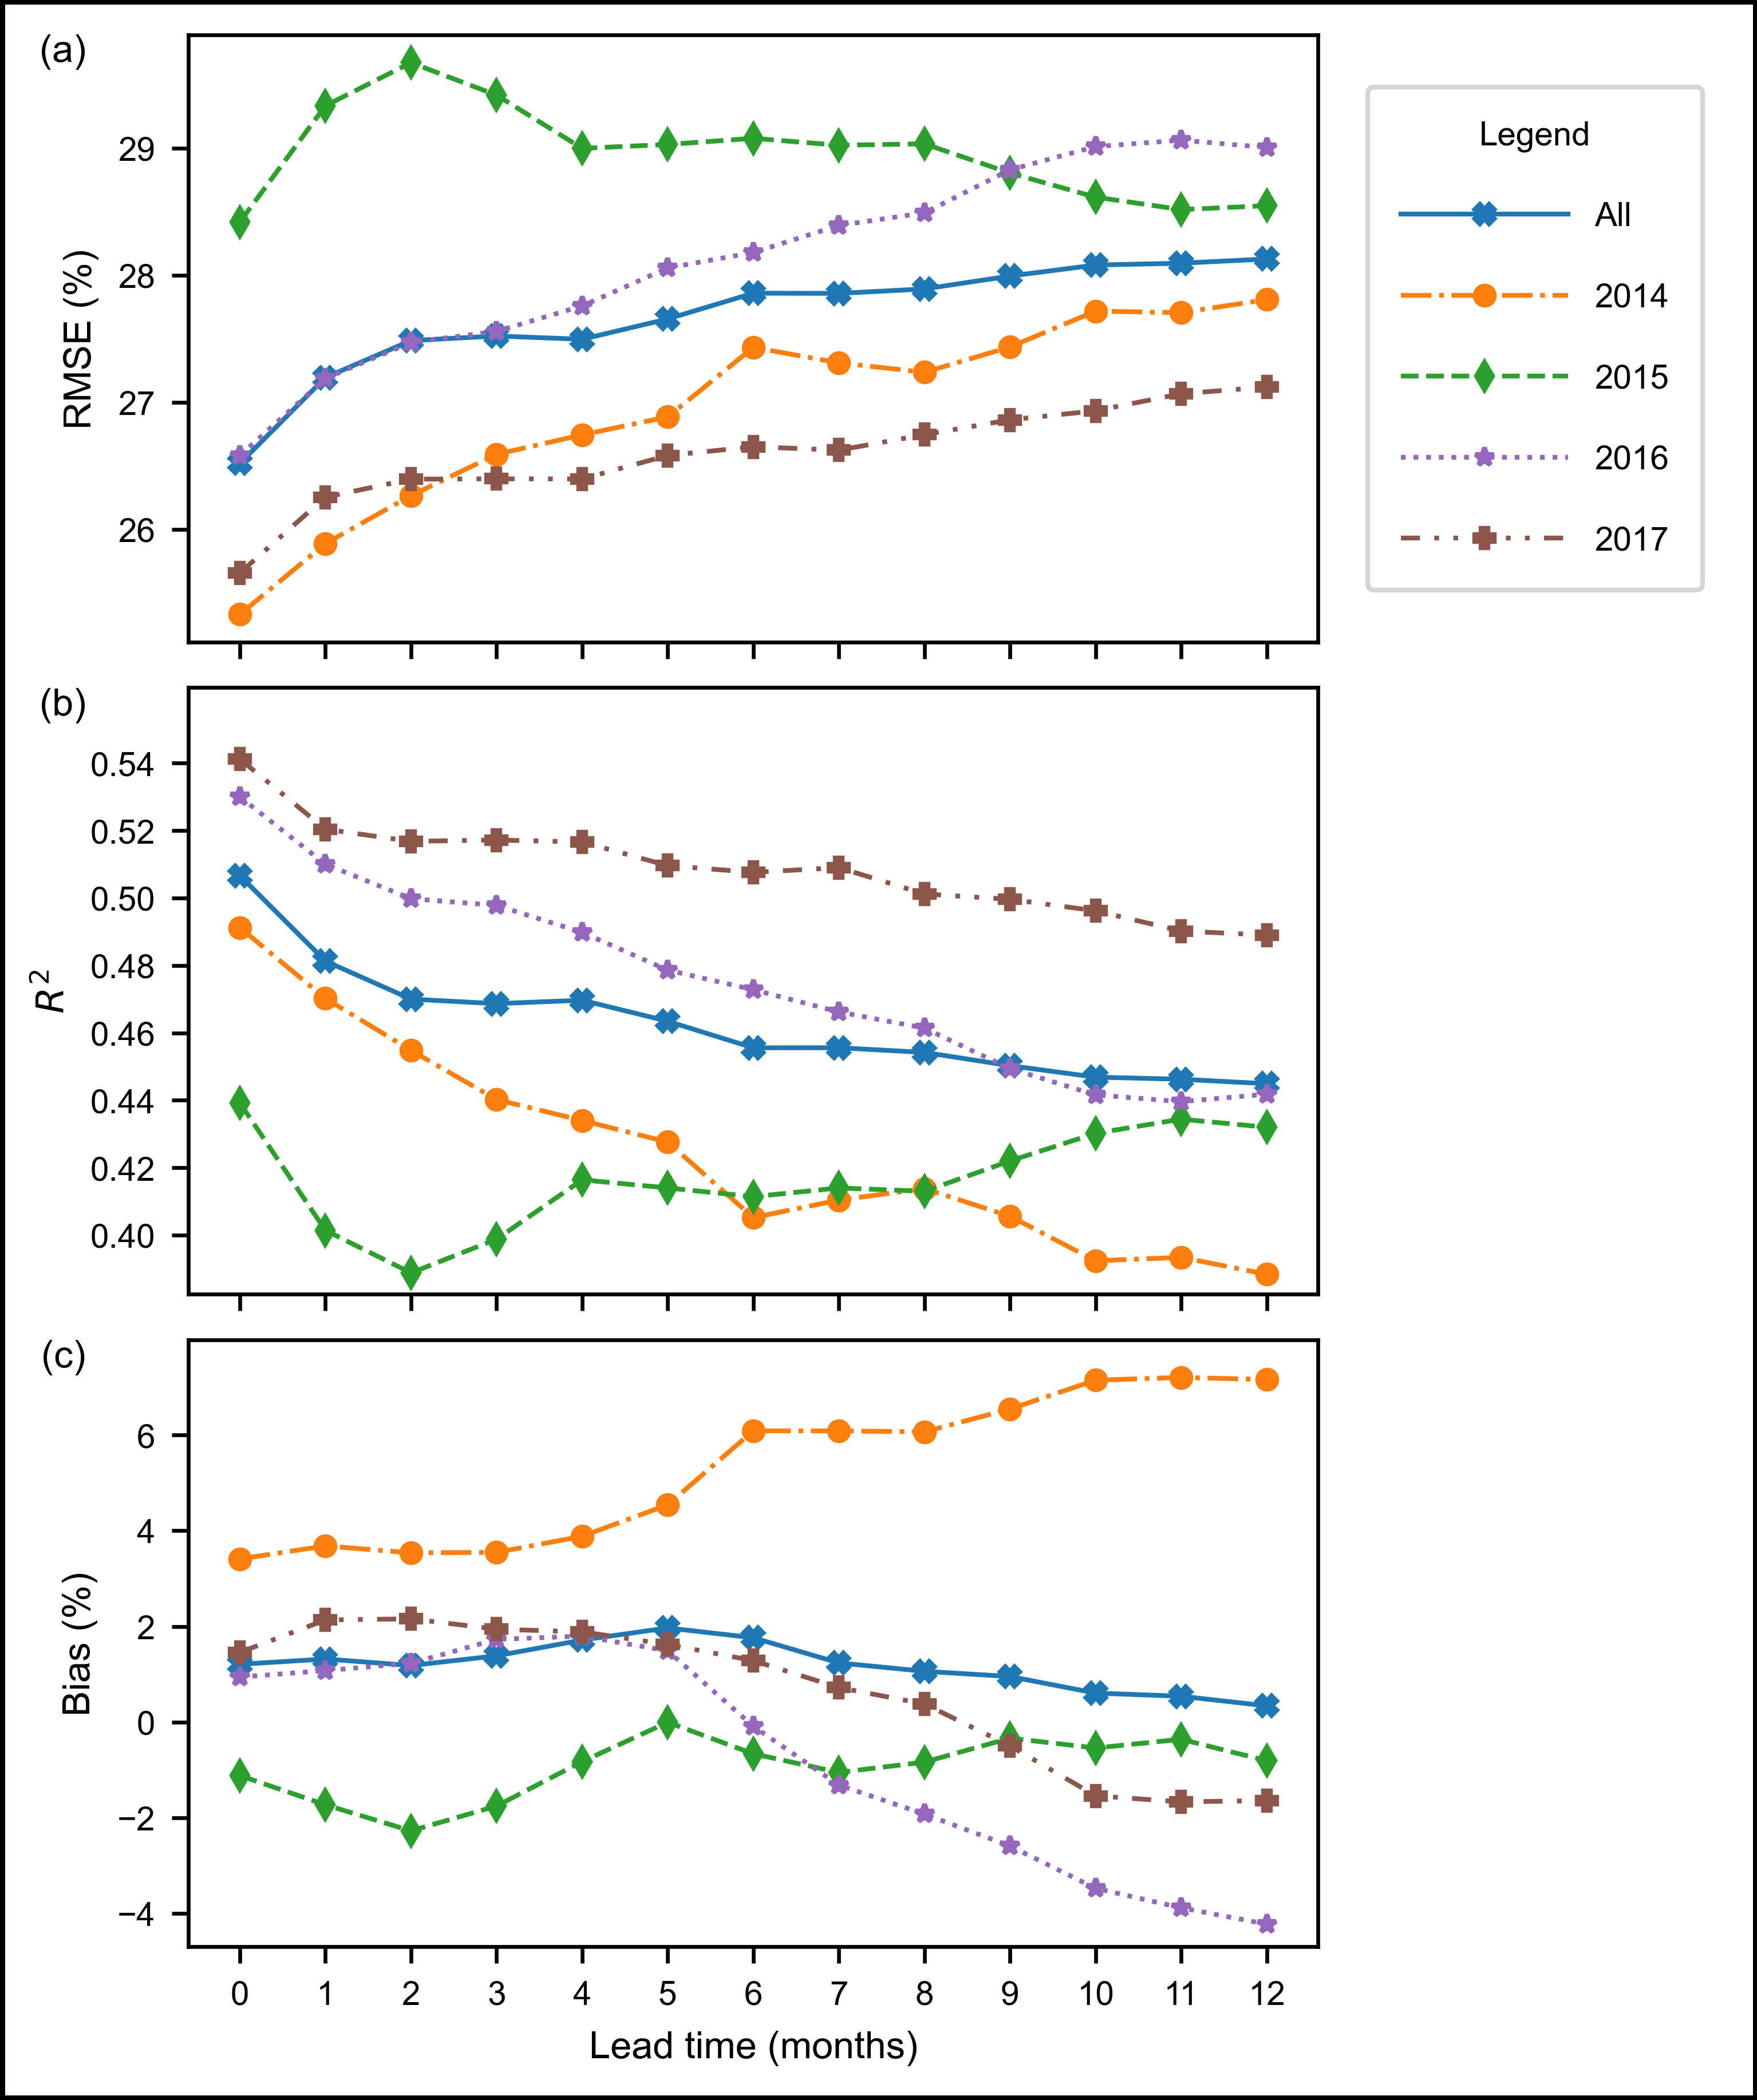

In [19]:
palette = [sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2], sns.color_palette()[4], sns.color_palette()[5]]
ls = ['-', '-.', '--', ':', (0, (4, 3, 1, 3, 1, 3))]
cycler = plt.cycler(linestyle=ls, color=palette, marker=['X', 'o', 'd', '*', 'P'])
font_size = 7
title_size = 8
plt.rcParams.update({'font.size': font_size})
plt.rcParams.update({'font.sans-serif': 'Arial'})
fig, ((ax1, ax4), (ax2, ax5), (ax3, ax6)) = plt.subplots(3, 2, figsize=(5, 6), gridspec_kw={'width_ratios': [3, 1]},
    sharex=True, sharey=False, constrained_layout=True, dpi=600, linewidth=2, edgecolor="black")

ax1.set_prop_cycle(cycler)
ax1 = rmse_df.plot.line(ax=ax1, linewidth=1, markersize=4)
ax1.set_xlabel('Lead time (months)', size=title_size)
ax1.set_ylabel('RMSE (%)', size=title_size)
ax1.set_xticks(np.arange(13))
ax1.set_xticklabels(np.arange(13), fontsize=font_size)
ax1.tick_params(labelsize=font_size)
ax1.text(-1.8, 29.9, '(a)', va='top', ha='right', fontsize=title_size)

ax2.set_prop_cycle(cycler)
ax2 = r2_df.plot(ax=ax2, linewidth=1, markersize=4)
ax2.set_xlabel('Lead time (months)', size=title_size)
ax2.set_ylabel('$R^2$', size=title_size)
ax2.set_xticks(np.arange(13))
ax2.set_xticklabels(np.arange(13))
ax2.tick_params(labelsize=font_size)
ax2.set_ylim((0.3825, 0.5625))
ax2.set_yticks(np.arange(40, 55, 2)/100)
ax2.text(-1.8, 0.5625, '(b)', va='top', ha='right', fontsize=title_size)

ax3.set_prop_cycle(cycler)
ax3 = bias_df.plot(ax=ax3, linewidth=1, markersize=4)
ax3.set_xlabel('Lead time (months)', size=title_size)
ax3.set_ylabel('Bias (%)', size=title_size)
ax3.set_xticks(np.arange(13))
ax3.set_ylim((-4.7, 7.99))
ax3.tick_params(labelsize=font_size)
ax3.set_xticklabels(np.arange(13))
ax3.text(-1.8, 8, '(c)', va='top', ha='right', fontsize=title_size)

lines, labels = ax3.get_legend_handles_labels()
ax4.axis('off')
ax5.axis('off')
ax6.axis('off')
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.legend(lines, labels, loc = 'center', title='Legend', fontsize=font_size, handlelength=5, labelspacing=1.5, borderpad=1) #, borderaxespad=0.4)

fig.savefig(os.path.join(common.FIGURES_DIR, 'Lead times.jpeg'), format="jpg", bbox_inches='tight', pad_inches=0.2, dpi=600)

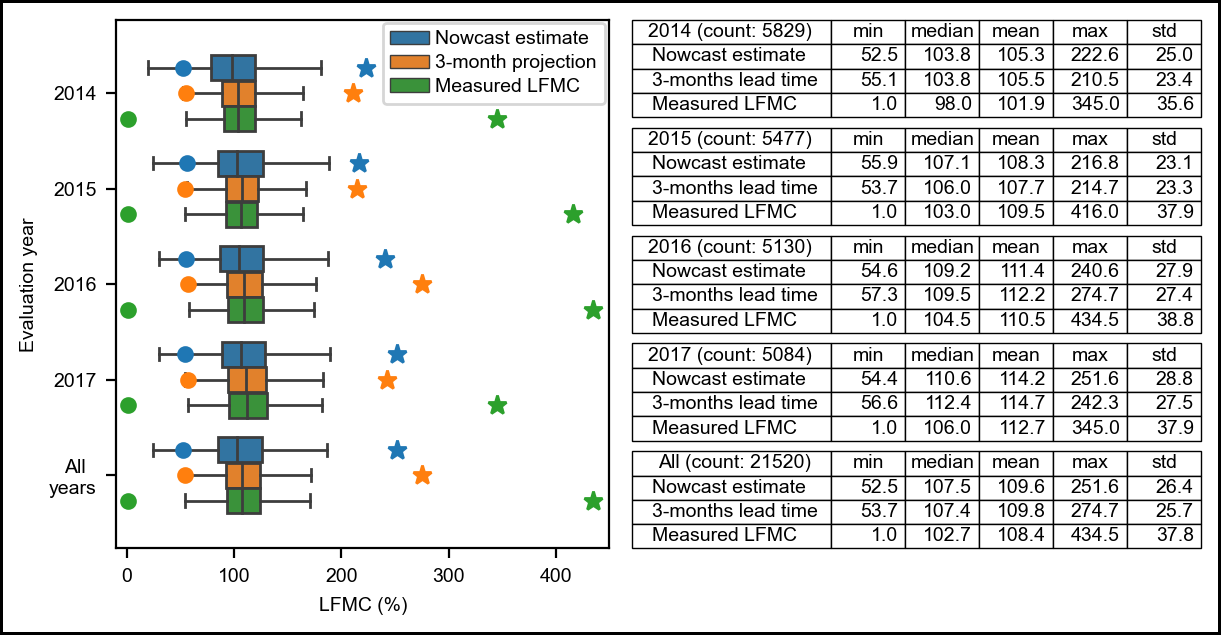

In [20]:
plt.rcParams['lines.linewidth'] = 0.5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5), dpi=200, linewidth=2, edgecolor="black")

ax = ax1
ax = sns.boxplot(x='LFMC (%)', y='Sampling year', hue='level_0', data=bp_data, showfliers=False, linewidth=1, ax=ax, orient='h',
                 order=[2014, 2015, 2016, 2017, 'All years'],
                 hue_order=['Nowcast estimate', '3-month projection', 'Measured LFMC'])

for xtick in ax.get_yticks():
    year_ = ax.get_yticklabels()[xtick].get_text()
    for pos, label in enumerate(['Nowcasting', '3-months lead time', 'Measured', ]):
        x_off = xtick + [-0.267, 0.0, .267][pos]
        
        # Add the minimums and maximums
        min_ = summ_df.loc[(year_, label), 'min']
        max_ = summ_df.loc[(year_, label), 'max']
        col_ = plt.rcParams["axes.prop_cycle"].by_key()["color"][pos]
        pt, = ax.plot(min_, x_off, 'ok', markersize=5, scalex=False,
                      mfc=col_, mec=col_)
        pt, = ax.plot(max_, x_off, '*k', markersize=7, scalex=False,
                      mfc=col_, mec=col_)

ax.set_ylabel('Evaluation year')
ax.set_yticklabels([2014, 2015, 2016, 2017, 'All  \nyears']) #, ha='center')
ax.legend(loc='upper right', bbox_to_anchor=(0.99, 0.995), labelspacing=0.3, borderpad=0.4, handletextpad=0.3, borderaxespad=0)
ax.set_xlim(-10, 450)

ax = ax2
ax.axis('off')
ax.axis('tight')
tab_font_size = 7
tab_col_widths = [0.1, 0.1, 0.1, 0.1, 0.1]
tab_line_width = 0.5
row_names = dict(zip(['Nowcasting', '3-month lead time', 'Measured'], ['Nowcast estimate', '3-month projection', 'Measured LFMC']))

temp_df = summ_df.loc['2014'].drop(columns='count').round(1).rename(row_names)
count_ = int(summ_df.loc['2014', 'count'][0])
tab1 = ax.table(cellText=temp_df.values, rowLabels=temp_df.index, colLabels=temp_df.columns,
                colWidths=tab_col_widths, bbox=[0.25, .816, 0.75, .184])
width_ = tab1[1, -1].get_width()
height_ = tab1[0, 0].get_height()
tab1.add_cell(0, -1, width=width_, height=height_, text=f'2014 (count: {count_})', fontproperties=dict(size=tab_font_size))
tab1.auto_set_font_size(False)
tab1.set_fontsize(tab_font_size)
for cell_ in tab1.get_children():
    cell_._linewidth = tab_line_width

temp_df = summ_df.loc['2015'].drop(columns='count').rename(row_names)
count_ = int(summ_df.loc['2015', 'count'][0])
tab2 = ax.table(cellText=temp_df.values, rowLabels=temp_df.index, colLabels=temp_df.columns, 
                colWidths=tab_col_widths, bbox=[0.25, .612, 0.75, .184])
width_ = tab2[1, -1].get_width()
height_ = tab2[0, 0].get_height()
tab2.add_cell(0, -1, width=width_, height=height_, text=f'2015 (count: {count_})', fontproperties=dict(size=tab_font_size))
tab2.auto_set_font_size(False)
tab2.set_fontsize(tab_font_size)
for cell_ in tab2.get_children():
    cell_._linewidth = tab_line_width

temp_df = summ_df.loc['2016'].drop(columns='count').rename(row_names)
count_ = int(summ_df.loc['2016', 'count'][0])
tab3 = ax.table(cellText=temp_df.values, rowLabels=temp_df.index, colLabels=temp_df.columns,
                colWidths=tab_col_widths, bbox=[0.25, .408, 0.75, .184])
width_ = tab3[1, -1].get_width()
height_ = tab3[0, 0].get_height()
tab3.add_cell(0, -1, width=width_, height=height_, text=f'2016 (count: {count_})', fontproperties=dict(size=tab_font_size))
tab3.auto_set_font_size(False)
tab3.set_fontsize(tab_font_size)
for cell_ in tab3.get_children():
    cell_._linewidth = tab_line_width

temp_df = summ_df.loc['2017'].drop(columns='count').rename(row_names)
count_ = int(summ_df.loc['2017', 'count'][0])
tab4 = ax.table(cellText=temp_df.values, rowLabels=temp_df.index, colLabels=temp_df.columns,
                colWidths=tab_col_widths, bbox=[0.25, .204, 0.75, .184])
width_ = tab4[1, -1].get_width()
height_ = tab4[0, 0].get_height()
tab4.add_cell(0, -1, width=width_, height=height_, text=f'2017 (count: {count_})', fontproperties=dict(size=tab_font_size))
tab4.auto_set_font_size(False)
tab4.set_fontsize(tab_font_size)
for cell_ in tab4.get_children():
    cell_._linewidth = tab_line_width

temp_df = summ_df.loc['All years'].drop(columns='count').rename(row_names)
count_ = int(summ_df.loc['All years', 'count'][0])
tab5 = ax.table(cellText=temp_df.values, rowLabels=temp_df.index, colLabels=temp_df.columns,
                colWidths=tab_col_widths, bbox=[0.25, 0, 0.75, .184])
width_ = tab5[1, -1].get_width()
height_ = tab5[0, 0].get_height()
tab5.add_cell(0, -1, width=width_, height=height_, text=f'All (count: {count_})', fontproperties=dict(size=tab_font_size))
tab5.auto_set_font_size(False)
tab5.set_fontsize(tab_font_size)
for cell_ in tab5.get_children():
    cell_._linewidth = tab_line_width

fig.savefig(os.path.join(common.FIGURES_DIR, 'Summary_stats.jpeg'), format="jpg", bbox_inches='tight', pad_inches=0.1, dpi=600)